In [1]:
# Importamos o Dataset do Kaggle
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
100% 225M/225M [00:11<00:00, 23.4MB/s]
100% 225M/225M [00:11<00:00, 21.2MB/s]


## Importações das bibliotecas

In [2]:
import zipfile
import os
import shutil
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

## Extração das pastas do dataset

In [3]:
zip_path = 'flowers-recognition.zip'
extract_path = '/content/flowers-recognition'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Divisão das imagens em pastas, Data augmentation, e adequação a Resnet

In [4]:
# Diretório base das imagens
base_dir = '/content/flowers-recognition/flowers'

# Criação de pastas para treino, validação e teste
base_output = '/content/flowers_dataset'
train_dir = os.path.join(base_output, 'train')
val_dir = os.path.join(base_output, 'val')
test_dir = os.path.join(base_output, 'test')

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Divisão do dataset em treino, validação e teste (80% treino, 10% validação, 10% teste)
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
        val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

        # Mover para pastas
        for img_set, output_dir in [(train_imgs, train_dir), (val_imgs, val_dir), (test_imgs, test_dir)]:
            output_category_dir = os.path.join(output_dir, category)
            os.makedirs(output_category_dir, exist_ok=True)
            for img in img_set:
                shutil.copy(os.path.join(category_path, img), os.path.join(output_category_dir, img))

# Adequação as imagens para o ResNet

IMG_SIZE = 224
BATCH_SIZE = 32

# Data Augmentation e normalização
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Geradores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


## Treinamento pelo Resnet e aplicação de fine-tuning.

In [5]:
# Carregar modelo pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Feature Extraction
base_model.trainable = False  # Congela as camadas do modelo base
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinamento inicial
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Fine-tuning
base_model.trainable = True  # Descongela algumas camadas para ajustar pesos
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 91s 678ms/step - accuracy: 0.4184 - loss: 1.7047 - val_accuracy: 0.7535 - val_loss: 0.7590
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 53s 490ms/step - accuracy: 0.6033 - loss: 1.0099 - val_accuracy: 0.7628 - val_loss: 0.7255
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 52s 480ms/step - accuracy: 0.5958 - loss: 0.9714 - val_accuracy: 0.7977 - val_loss: 0.6607
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 52s 478ms/step - accuracy: 0.6137 - loss: 0.9309 - val_accuracy: 0.7581 - val_loss: 0.6113
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 475ms/step - accuracy: 0.6185 - loss: 0.9074 - val_accuracy: 0.8116 - val_loss: 0.5650
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 52s 478ms/step - accuracy: 0.6689 - loss: 0.8134 - val_accuracy: 0.8093 - val_loss: 0.5729
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 53s 484ms/step - accuracy: 0.6640 - loss: 0.8168 - val_accuracy: 0.7907 - val_loss: 0.5887
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - accuracy: 0.6650 - loss: 0

## Extração das features para avaliar o resultado final

In [6]:
# Feature Extraction
final_train_acc_feature = history.history['accuracy'][-1]
final_val_acc_feature = history.history['val_accuracy'][-1]
final_train_loss_feature = history.history['loss'][-1]
final_val_loss_feature = history.history['val_loss'][-1]

print("===== Feature Extraction =====")
print(f"Acurácia final (Treino): {final_train_acc_feature:.4f}")
print(f"Acurácia final (Validação): {final_val_acc_feature:.4f}")
print(f"Perda final (Treino): {final_train_loss_feature:.4f}")
print(f"Perda final (Validação): {final_val_loss_feature:.4f}")

# Fine-Tuning
final_train_acc_finetune = history_finetune.history['accuracy'][-1]
final_val_acc_finetune = history_finetune.history['val_accuracy'][-1]
final_train_loss_finetune = history_finetune.history['loss'][-1]
final_val_loss_finetune = history_finetune.history['val_loss'][-1]

print("\n===== Fine-Tuning =====")
print(f"Acurácia final (Treino): {final_train_acc_finetune:.4f}")
print(f"Acurácia final (Validação): {final_val_acc_finetune:.4f}")
print(f"Perda final (Treino): {final_train_loss_finetune:.4f}")
print(f"Perda final (Validação): {final_val_loss_finetune:.4f}")


===== Feature Extraction =====
Acurácia final (Treino): 0.6770
Acurácia final (Validação): 0.8093
Perda final (Treino): 0.7988
Perda final (Validação): 0.4902

===== Fine-Tuning =====
Acurácia final (Treino): 0.9134
Acurácia final (Validação): 0.9186
Perda final (Treino): 0.2463
Perda final (Validação): 0.3581


## Gráfico de Acurácia
Gráfico que demonstra a acurácia antes e depois da aplicação do fine-tuning.

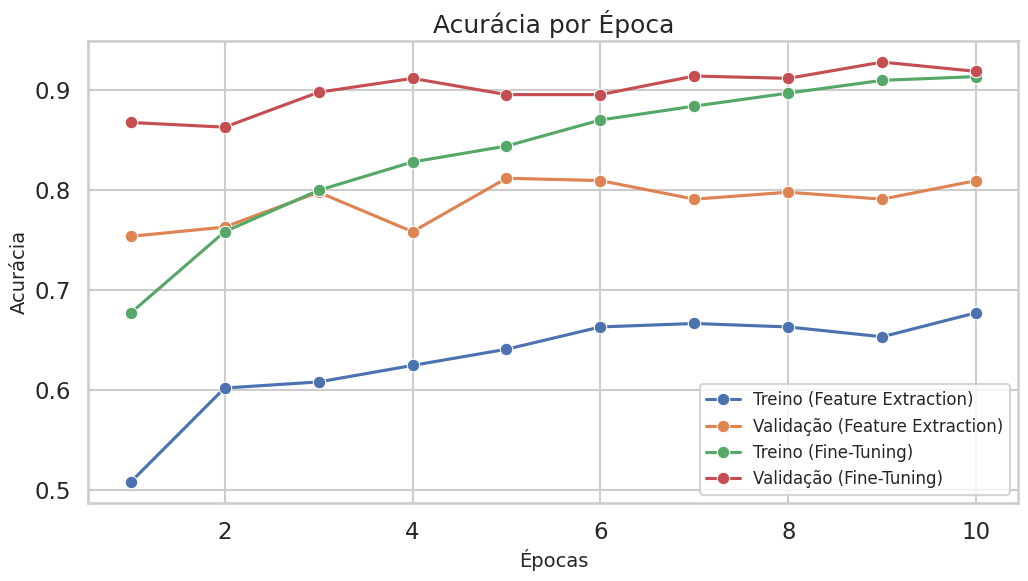

In [7]:
# Configuração do estilo do Seaborn
sns.set(style="whitegrid", context="talk")

# Dados para o gráfico
epochs_feature = range(1, len(history.history['accuracy']) + 1)
epochs_finetune = range(1, len(history_finetune.history['accuracy']) + 1)

# Criar o gráfico de Acurácia
plt.figure(figsize=(12, 6))
sns.lineplot(x=epochs_feature, y=history.history['accuracy'], label='Treino (Feature Extraction)', marker='o')
sns.lineplot(x=epochs_feature, y=history.history['val_accuracy'], label='Validação (Feature Extraction)', marker='o')
sns.lineplot(x=epochs_finetune, y=history_finetune.history['accuracy'], label='Treino (Fine-Tuning)', marker='o')
sns.lineplot(x=epochs_finetune, y=history_finetune.history['val_accuracy'], label='Validação (Fine-Tuning)', marker='o')

# Personalização
plt.title('Acurácia por Época', fontsize=18)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()


## Gráfico de perda
Abaixo uma comparação das perdas de treino e validação antes e depois do fine-tuning.

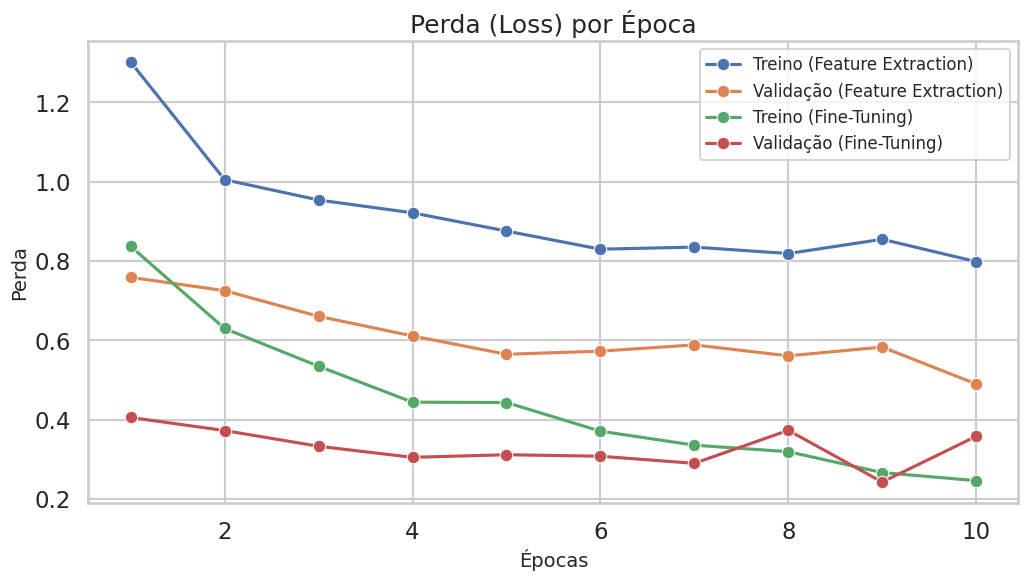

In [8]:
# Criar o gráfico de Perda
plt.figure(figsize=(12, 6))
sns.lineplot(x=epochs_feature, y=history.history['loss'], label='Treino (Feature Extraction)', marker='o')
sns.lineplot(x=epochs_feature, y=history.history['val_loss'], label='Validação (Feature Extraction)', marker='o')
sns.lineplot(x=epochs_finetune, y=history_finetune.history['loss'], label='Treino (Fine-Tuning)', marker='o')
sns.lineplot(x=epochs_finetune, y=history_finetune.history['val_loss'], label='Validação (Fine-Tuning)', marker='o')

# Personalização
plt.title('Perda (Loss) por Época', fontsize=18)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Perda', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.show()

## Testando uma imagem aléatoria

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


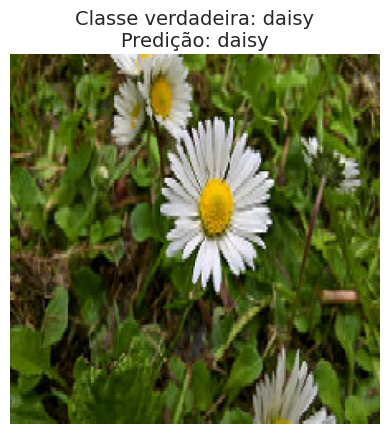

In [9]:
# Diretório do conjunto de teste
test_dir = '/content/flowers_dataset/test'

# Escolher uma classe aleatória e uma imagem aleatória dentro dela
random_class = random.choice(os.listdir(test_dir))
class_dir = os.path.join(test_dir, random_class)
random_image = random.choice(os.listdir(class_dir))
image_path = os.path.join(class_dir, random_image)

# Carregar e pré-processar a imagem
image = load_img(image_path, target_size=(224, 224))  # Tamanho do modelo (224x224)
image_array = img_to_array(image) / 255.0  # Normalizar os pixels
image_array = np.expand_dims(image_array, axis=0)  # Adicionar dimensão para batch

# Fazer a predição
predictions = model.predict(image_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = list(test_generator.class_indices.keys())[predicted_class_index]

# Mostrar a imagem e o resultado da predição
plt.imshow(image)
plt.axis('off')
plt.title(f"Classe verdadeira: {random_class}\nPredição: {predicted_class}", fontsize=14)
plt.show()
